# Circular heat plate

In [6]:
using MMJMesh
using MMJMesh.Meshes
using MMJMesh.Plots
using LinearAlgebra
using SparseArrays
using CairoMakie: spy, update_theme!

include("fem.jl")
include("heat.jl")

update_theme!(colormap=:acton)

## Parameters

In [18]:
p = (
    r = 2.2,
    λ = 2.19,
    w = 1.96
)

(r = 2.2, λ = 2.19, w = 1.96)

## Mesh

MakieCore.Plot{MMJMesh.Plots.mplot, Tuple{Mesh{2, 2, MMJMesh.Geometries.GeometricObjectI, MMJMesh.Geometries.GeometricObjectI}}}


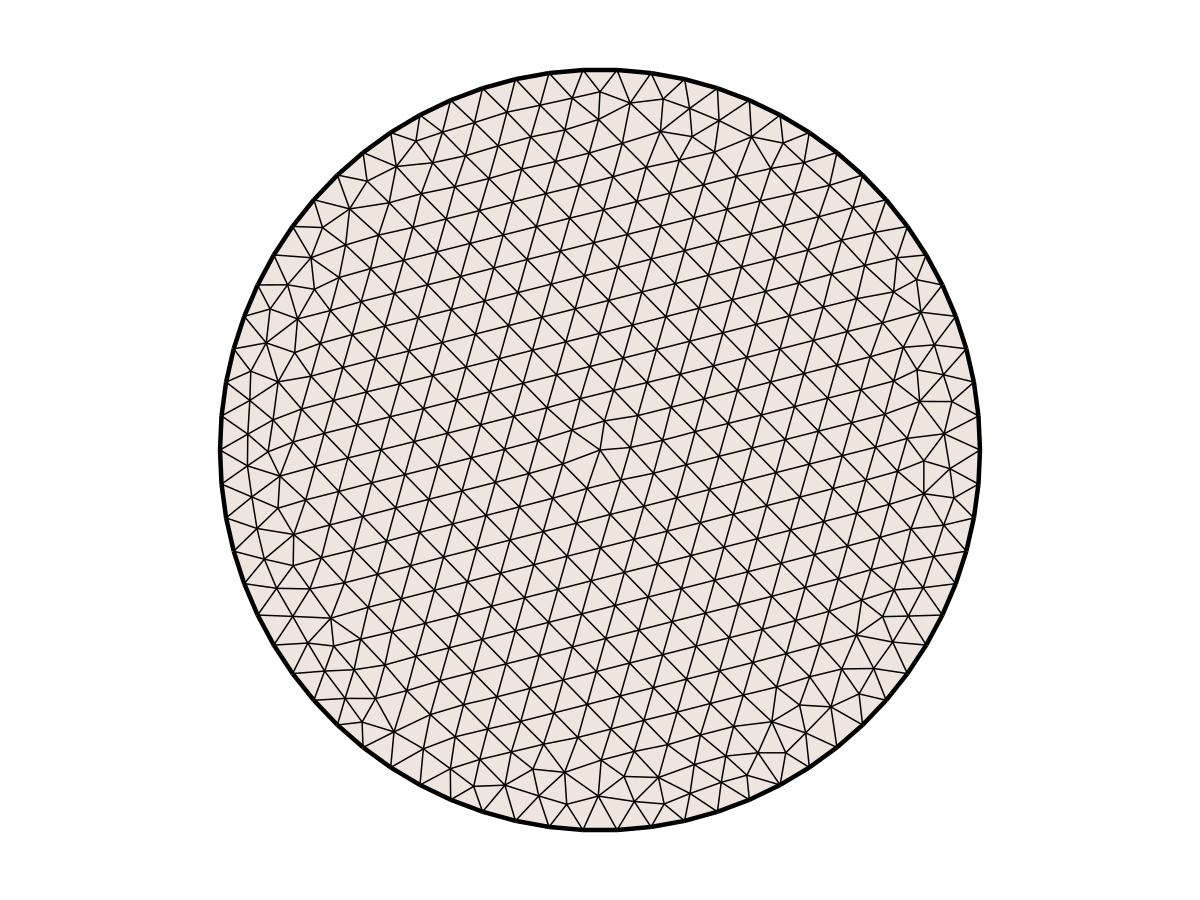

In [11]:
m = Mesh("gmsh/heat-plate.msh")
mplot(m, edgesvisible=true) |> mconf()

## Solution

### Define problem

In [12]:
setdata!(group(m, :elements), :ke_func, heat_ke(p.λ))
setdata!(group(m, :elements), :re_func, heat_re(p.w))

(::var"#refunc#14"{Float64}) (generic function with 1 method)

### Set up linear system

In [14]:
K, r = assemble_kr(m)
apply_dirichlet_bcs!(K, r, m.groups[:boundarynodes]);

### Solve

Linear system

In [16]:
θHat =  K \ r;

Comparison to exact solution

In [21]:
thetaMax = p.w * p.r^2 / (4 * p.λ)
thetaMaxH = maximum(θHat)

println("         Exact solution: thethaMax = ", thetaMax)
println("Finite element solution: thethaMax = ", thetaMaxH)
println("                             Error = ", 100 * abs(thetaMaxH - thetaMax) / thetaMax, "%")

         Exact solution: thethaMax = 1.082922374429224
Finite element solution: thethaMax = 1.0829968489489867
                             Error = 0.006877179890384774%


### Plot

MakieCore.Plot{MMJMesh.Plots.mplot, Tuple{Mesh{2, 2, MMJMesh.Geometries.GeometricObjectI, MMJMesh.Geometries.GeometricObjectI}, Vector{Float64}}}


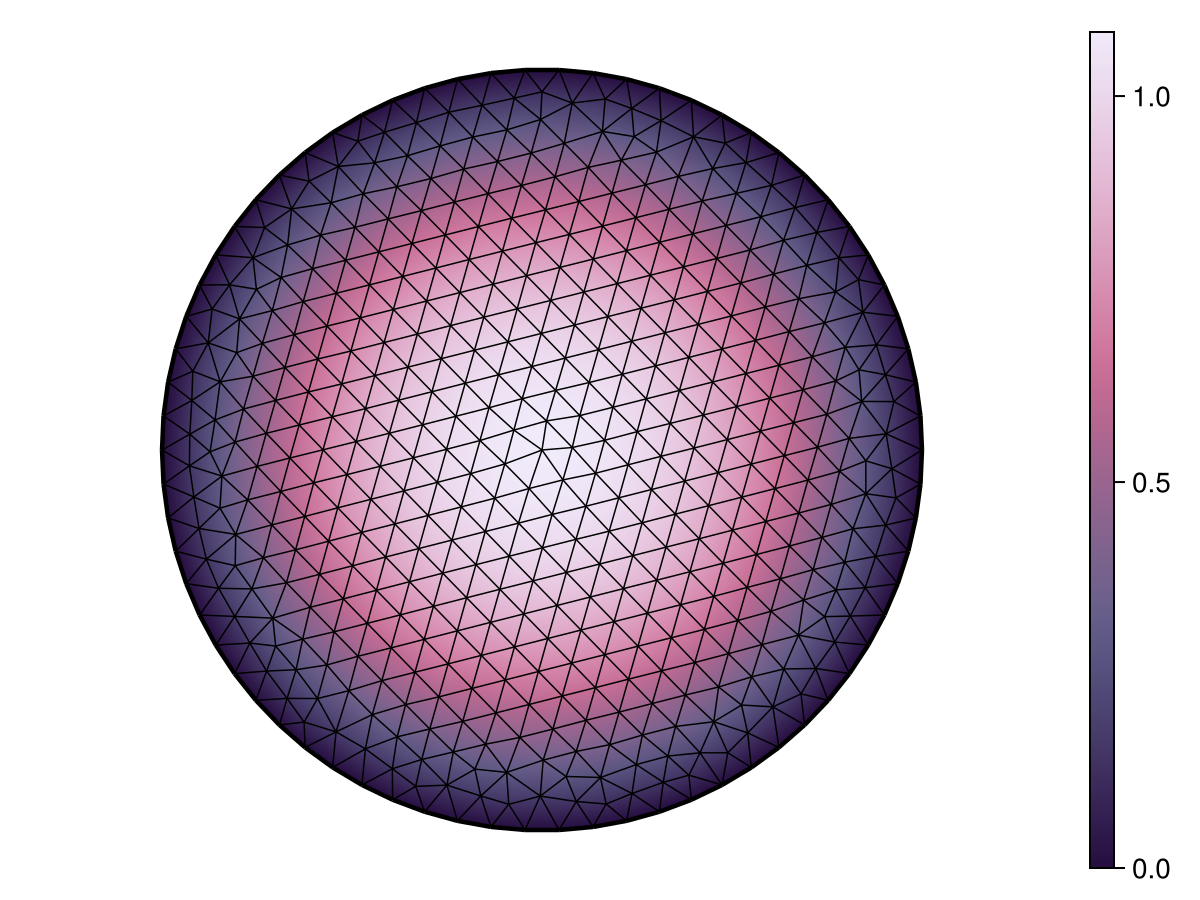

In [22]:
mplot(m, θHat, edgesvisible=true, edgecolor=:black) |> mconf()

Maximum error: 0.0008961519507375837
MakieCore.Plot{MMJMesh.Plots.mplot, Tuple{Mesh{2, 2, MMJMesh.Geometries.GeometricObjectI, MMJMesh.Geometries.GeometricObjectI}, Vector{Float64}}}


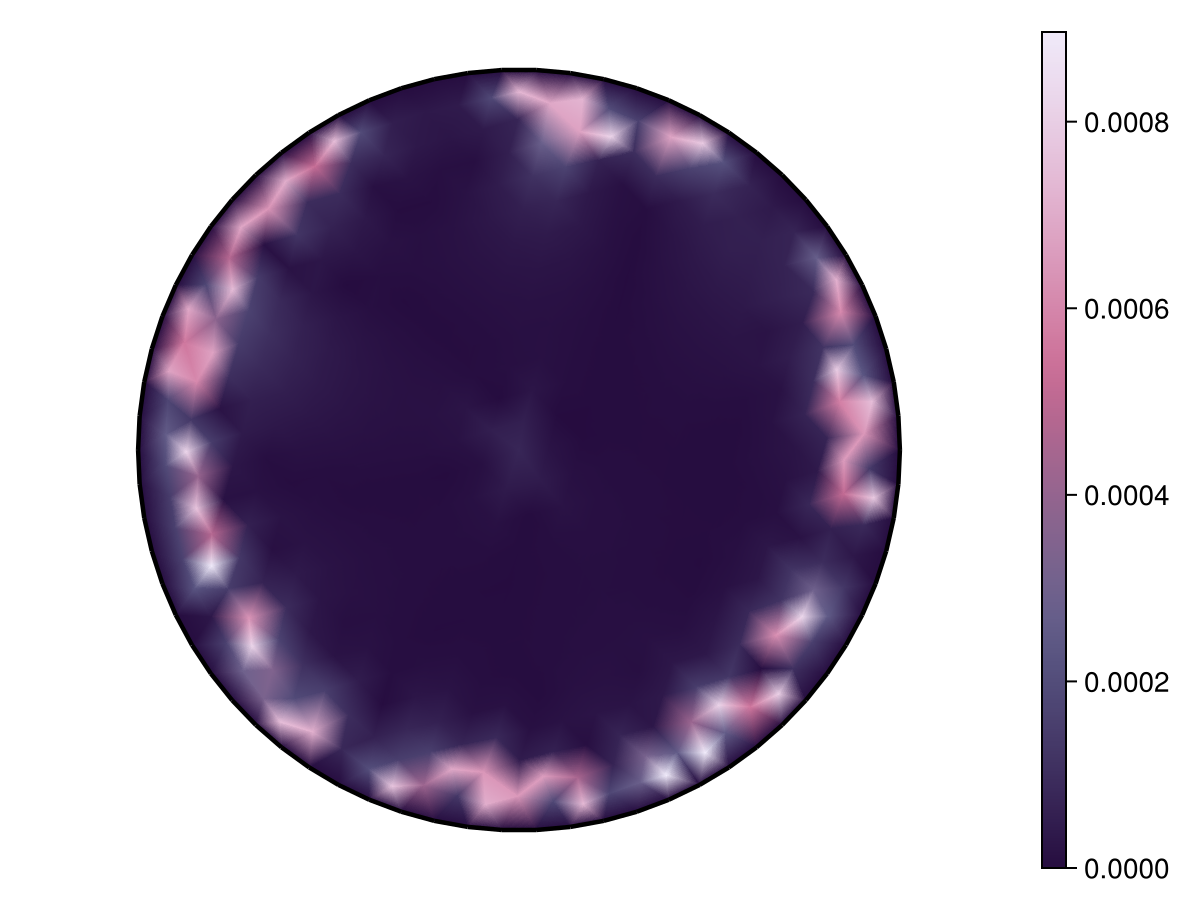

In [23]:
θ = p.w / (4 * p.λ) * (p.r^2 .- [norm(coordinates(m, i))^2 for i ∈ 1:nnodes(m)]) 
e = abs.(θHat - θ)
println("Maximum error: ", maximum(e))
mplot(m, e) |> mconf()

## Sparse Matrix

In [25]:
using SparseArrays
KSparse = sparse(K)
@time That =  K \ r;
@time That =  KSparse \ r;


  0.004433 seconds (9 allocations: 1.908 MiB)
  0.000715 seconds (96 allocations: 794.219 KiB)


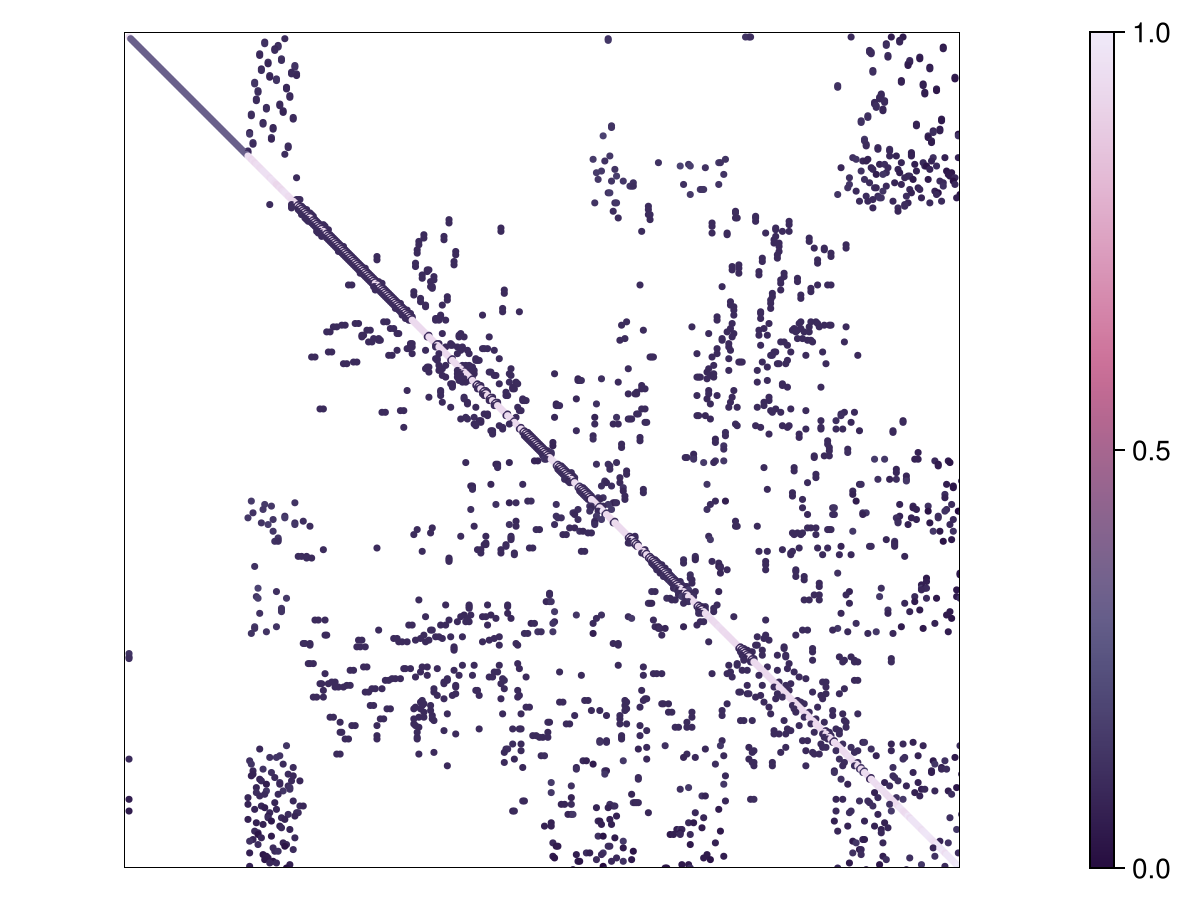

In [29]:
using CairoMakie: spy, hidedecorations!, hidespines!, Colorbar, DataAspect
sp = spy(sparse(K), markersize=6, marker=:circle) 
hidedecorations!(sp.axis)
hidespines!(sp.axis)
Colorbar(sp.figure[1, 2])
sp.axis.yreversed = true
sp.axis.aspect = DataAspect()
sp